$$
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \bigoplus_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{j,i}\right) \right),
$$
 where $\bigoplus$ denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean, min, max or mul, and
    $\gamma_{\mathbf{\Theta}}$ and $\phi_{\mathbf{\Theta}}$ denote
    differentiable functions such as MLPs.


In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## 定义图

In [2]:
edge_index = torch.LongTensor([[0, 0, 1, 2, 4, 4, 4], [1, 2, 2, 3, 0, 2, 3]])
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges)
data.edge_attr = edge_attr

print(data)
nxg = to_networkx(data)

Data(x=[5, 4], edge_index=[2, 7], edge_attr=[7])


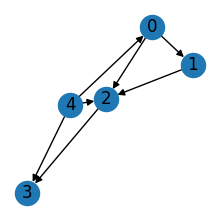

In [176]:
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

## GCNConv

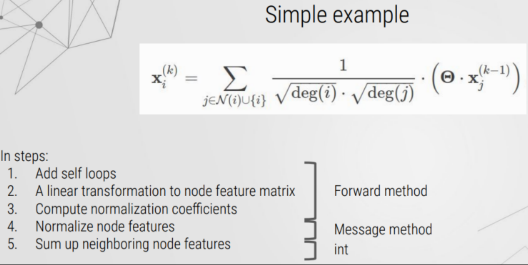

    
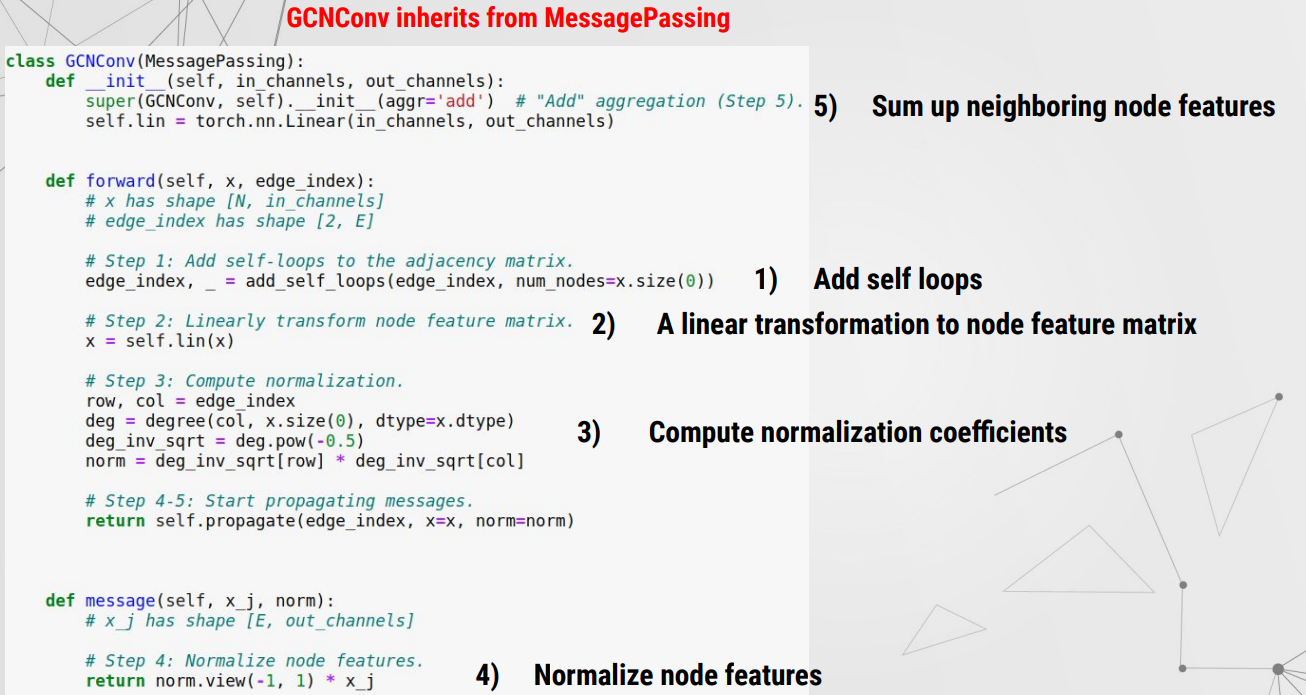


In [171]:
from torch_geometric.utils import add_self_loops, degree


class GCNConv(MessagePassing):
    def __init__(self, in_feat, out_feats):
        super(GCNConv, self).__init__(aggr="add")
        self.W = nn.Linear(in_feat, out_feats)
        torch.nn.init.ones_(self.W.weight)

        # self.bias = nn.Parameter(torch.empty(out_feats))
        # torch.nn.init.ones_(self.bias.data)

    def forward(self, x, edge_index):
        x = self.W(x)
        # 加自环为了避免度为0，分母
        edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)

        src, dst = edge_index
        # src是源，dst是目的，degree(src)是出度，degree(dst)是入度
        in_degrees = degree(dst, num_nodes=data.num_nodes)

        deg_inv_sqrt = in_degrees.pow(-0.5)
        # deg_inv_sqrt[src]是源的入度，deg_inv_sqrt[dst]是目的的入度
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]

        # 传递
        out = self.propagate(edge_index, x=x, norm=norm)
        return out
        # return out + self.bias

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
        # return会传入给aggregate，这里使用了add
        # 然后，我们调用 propagate()，它在内部调用 message()、aggregate() 和 update()。我们将节点嵌入 x 和归一化系数 norm 作为额外参数传递给信息传播。

In [172]:
in_feats = data.num_features
out_feats = 3
gcn = GCNConv(in_feats, out_feats)

In [174]:
with torch.no_grad():
    out = gcn(data.x, data.edge_index)
    print(out)

tensor([[10.8511, 10.8498, 11.6384],
        [ 1.6168,  1.6157,  2.2690],
        [10.8558, 10.8542, 11.8061],
        [15.0874, 15.0861, 15.8696],
        [15.6168, 15.6157, 16.2690]])


## TestLayer

Data(x=[6, 4], edge_index=[2, 8], edge_attr=[8])


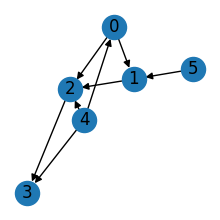

In [271]:
edge_index = torch.LongTensor(
    [
        [0, 0, 1, 2, 4, 4, 4, 5],
        [1, 2, 2, 3, 0, 2, 3, 1],
    ]
)
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges)
data.edge_attr = edge_attr

in_feats = data.num_features
out_feats = 3

print(data)
nxg = to_networkx(data)
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

In [284]:
from torch_geometric.utils import softmax as edge_softmax
from torch_scatter import scatter


class TestLayer(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(TestLayer, self).__init__(aggr="add")
        self.in_feats = in_feats
        self.out_feats = out_feats

        # Initialize learnable parameters
        self.weight = torch.nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.att = torch.nn.Parameter(torch.Tensor(1, 2 * out_feats))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.ones_(self.weight)
        torch.nn.init.ones_(self.att)

    def forward(self, data):
        x = data.x
        edge_attr = data.edge_attr
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        hw = x @ self.weight
        # print("in forward")
        # print("x\n", x)
        # print("hw\n", hw)
        # print("----------------------------------")
        out = self.propagate(
            edge_index=edge_index, x=x, hw=hw, num_nodes=num_nodes, data=data
        )
        print("in forward, after return")
        print("h\n", out)

    def message(self, x_i, x_j, hw_i, hw_j):
        # print("in message")
        # print("x_i\n", x_i)
        # print("x_j\n", x_j)
        # print("in message")
        # print("hw_i\n", hw_i)
        # print("hw_j\n", hw_j)
        # print("----------------------------------")
        return hw_i + hw_j

    def aggregate(self, ijsum, x, edge_index, hw):
        # print("in aggregate")
        # print('hw_i+hw_j\n',ijsum)
        # print('x\n',x)
        # print('edge_index\n',edge_index)
        # print('hw\n',hw)
        # print("----------------------------------")
        return ijsum

    def update(self, ijsum, edge_index, num_nodes):
        print("in update")
        # print("hw_i+hw_j\n", ijsum)
        h = scatter(
            src=ijsum, index=edge_index[1], dim=0, reduce="sum", dim_size=num_nodes
        )
        print("h\n", h)
        print("----------------------------------")

        e = self.edge_updater(edge_index, sum=h)
        print("in update, after edge_updater")
        print("e\n", e)

        return h

    def edge_update(self, edge_index, sum_i, sum_j):
        print("in edge_update")
        print("sum_i\n", sum_i)
        print("sum_j\n", sum_j)
        print("----------------------------------")

        print(sum_i + sum_j)
        e = edge_softmax(sum_i + sum_j, index=edge_index[1], dim=0)
        return e

In [285]:
# MessagePassing.forward?
# MessagePassing.message?
# MessagePassing.aggregate?
# MessagePassing.propagate?
# MessagePassing.edge_update?
# MessagePassing.edge_updater?

In [286]:
with torch.no_grad():
    model = TestLayer(in_feats, out_feats)
    model(data)

in update
h
 tensor([[16., 16., 16.],
        [28., 28., 28.],
        [44., 44., 44.],
        [48., 48., 48.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])
----------------------------------
in edge_update
sum_i
 tensor([[28., 28., 28.],
        [44., 44., 44.],
        [44., 44., 44.],
        [48., 48., 48.],
        [16., 16., 16.],
        [44., 44., 44.],
        [48., 48., 48.],
        [28., 28., 28.]])
sum_j
 tensor([[16., 16., 16.],
        [16., 16., 16.],
        [28., 28., 28.],
        [44., 44., 44.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])
----------------------------------
tensor([[44., 44., 44.],
        [60., 60., 60.],
        [72., 72., 72.],
        [92., 92., 92.],
        [16., 16., 16.],
        [44., 44., 44.],
        [48., 48., 48.],
        [28., 28., 28.]])
in update, after edge_updater
e
 tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00],
        [6.1442e-06, 6.1442e-06, 6.1442e-06],
        [

## GATLayer

Data(x=[6, 4], edge_index=[2, 8], edge_attr=[8])


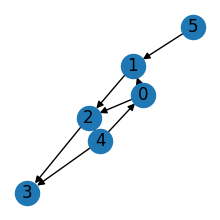

In [344]:
# 定义图
edge_index = torch.LongTensor(
    [
        [0, 0, 1, 2, 4, 4, 4, 5],
        [1, 2, 2, 3, 0, 2, 3, 1],
    ]
)
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges)
data.edge_attr = edge_attr

in_feats = data.num_features
out_feats = 3

print(data)
nxg = to_networkx(data)
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

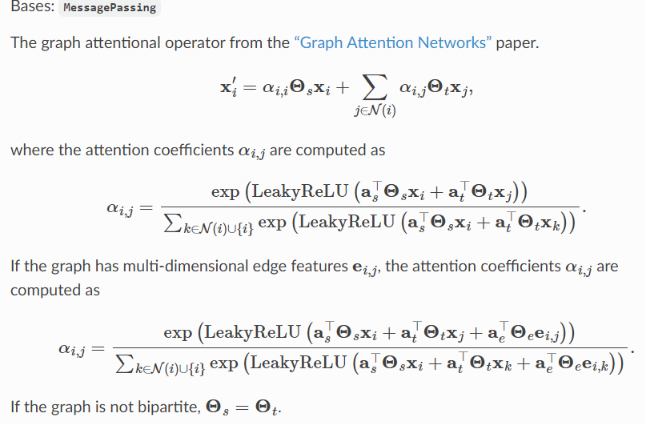

In [419]:
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.utils import softmax as edge_softmax


class GATLayer(MessagePassing):
    def __init__(self, in_feats, out_feats, edge_dim):
        super(GATLayer, self).__init__(aggr="add")
        self.edge_dim = edge_dim
        self.w_node = nn.Parameter(torch.ones(in_feats, out_feats))

        # self.w_n=nn.Parameter(torch.ones(in_feats,out_feats))
        self.att_self = nn.Parameter(torch.ones(out_feats, 1))
        self.att_neih = nn.Parameter(torch.ones(out_feats, 1))

        self.w_edge = nn.Parameter(torch.ones(edge_dim, out_feats))
        self.att_edge = nn.Parameter(torch.ones(out_feats, 1))

        self.alpha = None

    def forward(self, edge_index, x, edge_attr, get_attention=False):
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(
            edge_index, edge_attr, fill_value="mean", num_nodes=x.shape[0]
        )
        # 以防有入度为0的节点，因为GAT需要自身节点的特征

        edge_attr = edge_attr.view(-1, self.edge_dim)
        wx = x @ self.w_node
        we = edge_attr @ self.w_edge
        alpha = self.edge_updater(edge_index, wx=wx, we=we)

        out = self.propagate(edge_index, wx=wx, alpha=alpha)

        if get_attention:
            return out, alpha
        else:
            return out

    def message(self, edge_index, wx_j, alpha):
        # print("in message")
        # print(wx_j)
        # print(alpha)
        return alpha * wx_j

    def edge_update(self, wx_i, wx_j, we, edge_index):
        wx_iatt = wx_i @ self.att_self
        wx_jatt = wx_j @ self.att_neih
        weatt = we @ self.att_edge

        e = wx_iatt + wx_jatt + weatt
        e = F.leaky_relu(e)

        alpha = edge_softmax(e, edge_index[1])
        return alpha

        # print(wx_iatt.shape)
        # print(weatt.shape)

In [420]:
model = GATLayer(in_feats, out_feats, edge_dim=1)
with torch.no_grad():
    out,attention=model(edge_index, data.x, data.edge_attr,get_attention=True)

NotImplementedError: 

In [421]:
print(out)

tensor([[16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])


In [416]:
print(attention.shape)

torch.Size([14, 1])
